In [77]:
import pandas as pd
import numpy as np
import re
import os
import pickle

# NLP
import nltk
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Prepocesamiento
from sklearn.preprocessing import MinMaxScaler

# Train-Test, Validación
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# Regresores
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor

# Metricas para regresiones
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score

# Visualizaciones
import plotly.express as px

#### Carga del dataset completo de comentarios

In [14]:
df_completo = pd.read_csv("Data/100178_Comentarios.csv", sep=";")

#### Extracción de la feature "texto" y el target "karma"

In [26]:
df = df_completo[["texto", "karma"]]
df.shape

(100178, 2)

#### Eliminación de valores nulos y conversión de tipo

In [27]:
print(f"Total de nulos por columna\n{df.isna().sum()}")
df = df.dropna()
df["karma"] = df["karma"].astype("int32")
df.reset_index(inplace=True, drop=True)
df.shape

Total de nulos por columna
texto     33
karma    785
dtype: int64


(99360, 2)

#### Definición de funciónes auxiliares

In [2]:
# Cargar de las stopwords en español de nltk
stopwords = nltk.corpus.stopwords.words("spanish")

# Cargar del modelo de lenguaje para español de Spacy
nlp = spacy.load("es_core_news_sm")

# Función para la limpieza de comentarios
def limpieza_texto(texto: str):
    '''
    Función de limpieza de texto que elimina números, signos de puntuación y caractereres no alfanuméricos.\n
    Elimina stopwords, lematiza la entrada y devuelve una cadena de texto con todas las palabras de más de 2 letras. \n
    Necesita definición previa de la lista de "stopwords" y la inicialización del modelo de lenguaje de Spacy en la variable "nlp"
    '''
    texto = re.sub(r'[^a-zA-Z0-9\sáéíóúñçÁÉÍÓÚäëïöüàèìòù]', ' ', texto)
    texto = re.sub(r'\d+', '', texto)

    # Lematización
    comentario_nlp = nlp(texto)
    lemmas = [token.lemma_ for token in comentario_nlp]
    comentario_stopwords = ' '.join(lemmas)
    
    # Elimnación de Stopwords y palabras de menos de 3 letras
    tokens_limpios = [palabra for palabra in comentario_stopwords.split(" ") if palabra.lower() not in stopwords and len(palabra) > 2]
    
    return ' '.join(tokens_limpios)

# Función para eliminar hapaxes
def eliminar_palabras(texto: str, lista: list[str]):
    '''
    Elimina de un texto dado las palabras contenidas en la lista de palabras provista
    '''    
    texto_limpio = ' '.join([palabra for palabra in texto.split(" ") if palabra not in lista])
    return texto_limpio

def DistribucionPalabras_RiquezaLexica(datos: str):
    '''
    Función para mostrar la riqueza léxica de un texto.\n
    Retorna la distribución de palabras (nltk.FreqDist).
    
    '''
    # Tokenización del texto y generación de la distribución
    tokens = nltk.word_tokenize(text = datos, language = "spanish") 
    texto_nltk = nltk.Text(tokens = tokens)
    distribucion = nltk.FreqDist(samples = texto_nltk)

    # Obtención de la riqueza Léxica
    total_palabras = len(tokens)
    palabras_diferentes = len(set(tokens))
    riqueza_lexica = round((palabras_diferentes / total_palabras) * 100, 2)
    
    # Obtención de hapaxes
    hapaxes = distribucion.hapaxes()

    print(f"Total de palabras: {total_palabras}")
    print(f"Palabras diferentes: {palabras_diferentes}")
    print(f"Riqueza Lexica: {riqueza_lexica}% palabras distintas")
    print (f"Número total de hapaxes: {len(hapaxes)}")

    return distribucion

### Limpieza del texto
Se eliminan también los posibles nulos resultantes tras la limpieza

In [29]:
df["texto"] = df["texto"].apply(limpieza_texto)
df = df.dropna()
df.reset_index(inplace=True, drop=True)
df.shape

,texto,karma
0,dar hostia hartar ser despreciabl haber conseg...,77
1,ser ser opción seguro preferir muerto cerdo ll...,35
2,saludo Mysto hermoso,51
3,ser tal ser desproposito barbarie caber cosa d...,52
4,ser problema querer rebajar llegar punto pensa...,33


##### Exportacion Intermedia de Datos y obtención del texto completo

In [ ]:
# df.to_csv("Data/100K_Comentarios_TrasLimpieza.csv", sep=";", encoding="utf-8",  index=False)
try:
    with open("Data/Texto_Comentarios_100K.txt", mode="r", encoding="utf-8") as file:
        texto_completo = file.read()
except:
    texto_completo = ""
    try:
        os.mkdir("Data")
    except:
        pass
    with open("Data/Texto_Comentarios_100K.txt", mode="w", encoding="utf-8") as file:
        for fila in df["texto"].values:
            file.write(fila + " ")
            texto_completo += fila + " "

### Generación y graficado de la Distribución de palabras y muestra de la riqueza léxica

Total de palabras: 1860683
Palabras diferentes: 93413
Riqueza Lexica: 5.02% palabras distintas
Número total de hapaxes: 49376


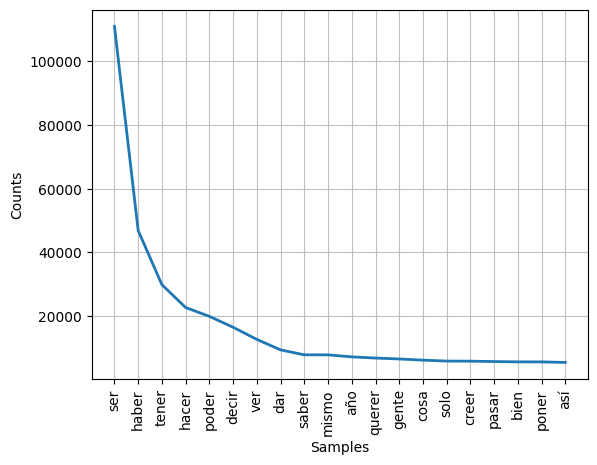

In [47]:
distribucion = DistribucionPalabras_RiquezaLexica(texto_completo)
distribucion.plot(20)

### Obtención de hapaxes y aplicación de la función de eliminación

In [48]:
hapaxes = distribucion.hapaxes()
df["texto"] = df["texto"].apply(lambda x: eliminar_palabras(x, hapaxes))

#### Exportación intermedia de datos

In [3]:
try:
    df = pd.read_csv("Data/100KComentarios_Procesados.csv", sep=";", encoding="utf-8")
except:
    try:
        os.mkdir("Data")
    except:
        pass
    df.to_csv("Data/100KComentarios_Procesados.csv", sep=";", encoding="utf-8", index=False)

try:
    with open("Data/Texto_Comentarios_100K_Procesados.txt", mode="r", encoding="utf-8") as file:
        texto_completo_procesado = file.read()
except:
    texto_completo_procesado = ""
    
    try:
        os.mkdir("Data")
    except:
        pass
    
    with open("Data/Texto_Comentarios_100K_Procesados.txt", mode="w", encoding="utf-8") as file:
        for fila in df["texto"].values:
            file.write(fila + " ")
            texto_completo_procesado += fila + " "

### Distribución tras la eliminación de hapaxes

Total de palabras: 1811309
Palabras diferentes: 44039
Riqueza Lexica: 2.43% palabras distintas
Número total de hapaxes: 2


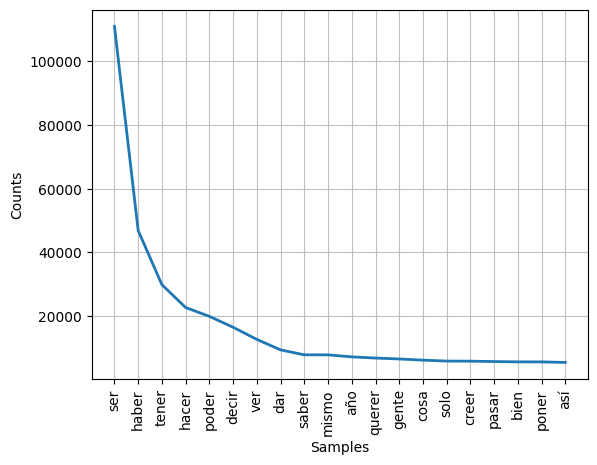

In [83]:
distribucion = DistribucionPalabras_RiquezaLexica(texto_completo_procesado)
distribucion.plot(20)

### Distribución de la variable objetivo "karma"
Se observa que la variable toma valores negativos y sufre un desbalanceo de la distribución.

In [4]:
px.histogram(df["karma"], marginal="box")

### Tratamiento de outliers

1º - Escalado para eliminar valores negativos

2º - Normalización con la función logaritmica. Se añade desplazamiento para evitar el logaritmo de 0.

In [10]:
karma_scaler = MinMaxScaler()
karma_escalado = karma_scaler.fit_transform(df["karma"].values.reshape(-1,1))
karma_normalizado = np.log(karma_escalado + 1)
px.histogram(karma_normalizado, marginal="box")

Obtención de los cuantiles, el rango intercuartil y los bigotes

In [41]:
karma_Q1 = pd.DataFrame(karma_normalizado)[0].describe()["25%"]
karma_Q3 = pd.DataFrame(karma_normalizado)[0].describe()["75%"]

karma_RIC = karma_Q3 - karma_Q1

bigote_superior = karma_Q3 + 1.5*karma_RIC
bigote_inferior = karma_Q1 - 1.5*karma_RIC

Transformación inversa (exponenciación) y desescalado

In [42]:
bigote_superior = int(round(karma_scaler.inverse_transform((np.exp(bigote_superior) - 1).reshape(1,-1))[0][0],0))
bigote_inferior = int(round(karma_scaler.inverse_transform((np.exp(bigote_inferior) - 1).reshape(1,-1))[0][0],0))
print(f"Bigote superior: {bigote_superior}\nBigote inferior: {bigote_inferior}")

Bigote superior: 58
Bigote inferior: -22


#### Eliminación de Outliers de acuerdo a los bigotes

In [44]:
df = df[(df["karma"] >= bigote_inferior) & (df["karma"] <= bigote_superior)]
df.reset_index(inplace=True, drop=True)

#### Conteo y Vectorizado de las palabras

In [54]:
# Inicializamos un objeto CountVecrtorizer()
count_vectorizer = CountVectorizer()

# Entrenamos el modelo y transformamos los datos.
bag = count_vectorizer.fit_transform(df["texto"])

bag

<87041x38488 sparse matrix of type '<class 'numpy.int64'>'
	with 1359922 stored elements in Compressed Sparse Row format>

#### Transformación de la matriz de palabras por frecuencias

In [55]:
# Inicializamos un objeto Tfidf
tfidf = TfidfTransformer()

# Entrenamos el Tfidf y transformamos la variable bag
bag_tfidf = tfidf.fit_transform(bag)
bag_tfidf

<87041x38488 sparse matrix of type '<class 'numpy.float64'>'
	with 1359922 stored elements in Compressed Sparse Row format>

#### Creación de los grupos de train/test

In [56]:
X_train, X_test, y_train, y_test = train_test_split(bag_tfidf, # X
                                                    df["karma"].values, # y
                                                    test_size = 0.3, random_state = 42)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape},  y_test: {y_test.shape}")

X_train: (60928, 38488), y_train: (60928,)
X_test: (26113, 38488),  y_test: (26113,)


#### Escalado del target para eliminar valores negativos

In [57]:
y_scaler = MinMaxScaler()
y_train = y_scaler.fit_transform(y_train.reshape(-1,1))
y_test = y_scaler.transform(y_test.reshape(-1,1))

#### Transformación logarítmica para acercarse a una distribución normal (gaussiana)

In [73]:
y_train = np.log(y_train + 1)
y_test = np.log(y_test + 1)

#### Listado inicial de modelos

Se descartan RadiusNeighborsRegressor, RandomForestRegressor y SVR por su coste computacional

In [11]:
modelos = [LinearRegression(),
            KNeighborsRegressor(),            
            DecisionTreeRegressor(),            
            AdaBoostRegressor(),
            GradientBoostingRegressor()]

#### Entrenamiento y predicción con todos los modelos y generación de métricas

In [ ]:
datos_modelos = list()

for model in modelos:
    print (f"    #### Modelo: {str(model)} ####")
    model.fit(X_train, y_train.reshape(-1,))
    yhat = model.predict(X_test)

    y_test_inv = np.exp(y_test) - 1
    yhat_inv = np.exp(yhat) - 1

    y_test_inv = y_scaler.inverse_transform(y_test_inv)
    yhat_inv = y_scaler.inverse_transform(yhat_inv.reshape(-1,1))

    #Metricas
    mae = mean_absolute_error(y_test_inv, yhat_inv)
    mse = mean_squared_error(y_test_inv, yhat_inv)
    rmse = root_mean_squared_error(y_test_inv, yhat_inv)
    r2 = r2_score(y_test_inv, yhat_inv)
    
    datos_modelos.append([str(model).strip("()"), model, mae, mse, rmse, r2])
    print(f"-MAE: {mae}  -MSE: {mse}  -RMSE: {rmse}  -R2: {r2}")

df_modelo = pd.DataFrame(data = datos_modelos, columns = ["name", "model", "mae", "mse", "rmse", "r2"])
df_modelo.sort_values("mae", ascending = False)

#### Determinamos el modelo con mejores métricas - GradientBoostingRegressor
Imprimimos las métricas como referencia

In [68]:
model = GradientBoostingRegressor()
print (f"#### Modelo: {str(model).strip('()')} ####")
model.fit(X_train, y_train.reshape(-1,))
yhat = model.predict(X_test)

y_test_inv = np.exp(y_test) - 1
yhat_inv = np.exp(yhat) - 1

y_test_inv = y_scaler.inverse_transform(y_test_inv)
yhat_inv = y_scaler.inverse_transform(yhat_inv.reshape(-1,1))

#Metricas
mae = mean_absolute_error(y_test_inv, yhat_inv)
mse = mean_squared_error(y_test_inv, yhat_inv)
rmse = root_mean_squared_error(y_test_inv, yhat_inv)
r2 = r2_score(y_test_inv, yhat_inv)

print(f"MAE: {mae}\nMSE: {mse}\nRMSE: {rmse}\nR2: {r2}")

#### Modelo: GradientBoostingRegressor ####
MAE: 9.290402316176914
MSE: 149.8982110193126
RMSE: 12.2432924909647
R2: 0.0012767793395013216


 #### Procedemos a la validación mediante KFold

In [70]:
# Elegimos realizar 5 folds.
Validacion_kfold = KFold(n_splits = 5)

# Creación de listas para los resultados generales y parciales
lista_targets = list()
lista_predicciones = list()
lista_mae = list()
lista_rmse = list()

i = 0

for train_index, test_index in Validacion_kfold.split(df):
    i += 1
    print (f"#### Fold {i} ####")
    
    # Creación de los conjuntos de Train y Test
    X_train, X_test = bag_tfidf[train_index], bag_tfidf[test_index]
    y_train, y_test = df["karma"][train_index].values, df["karma"][test_index].values

    # Normalización de la columna objetivo en ambos conjuntos
    y_scaler = MinMaxScaler()
    y_train = y_scaler.fit_transform(y_train.reshape(-1,1))
    y_test = y_scaler.transform(y_test.reshape(-1,1))
    y_train = np.log(y_train + 1)
    y_test = np.log(y_test + 1)
    
    # Creación y entrenamiento del Modelo    
    GradientBoosting = GradientBoostingRegressor()
    GradientBoosting.fit(X_train, y_train.reshape(-1,))

    # Prediccion
    yhat = GradientBoosting.predict(X_test)

    y_test_inv = np.exp(y_test) - 1
    yhat_inv = np.exp(yhat) - 1

    y_test_inv = y_scaler.inverse_transform(y_test_inv)
    yhat_inv = y_scaler.inverse_transform(yhat_inv.reshape(-1,1))

    # Metricas
    mae = mean_absolute_error(y_test_inv, yhat_inv)    
    rmse = root_mean_squared_error(y_test_inv, yhat_inv)
    print(f"MAE: {mae}\nRMSE: {rmse}\n")

    # Se añaden las métricas a listas
    lista_targets.extend(y_test_inv)
    lista_predicciones.extend(yhat_inv)
    lista_mae.append(mae)
    lista_rmse.append(rmse)

# Se calcula el desempeño general y se imprimen los rangos de las métricas observadas
print(f"GENERAL MAE:\t {mean_absolute_error(lista_targets, lista_predicciones)}")
print(f"GENERAL RMSE:\t {root_mean_squared_error(lista_targets, lista_predicciones)}\n")

print(f"Min de MAE: {np.array(lista_mae).min()}")
print(f"Media de MAE: {np.array(lista_mae).mean()}")
print(f"Max de MAE: {np.array(lista_mae).max()}\n")

print(f"Min de RMSE: {np.array(lista_rmse).min()}")
print(f"Media de RMSE: {np.array(lista_rmse).mean()}")
print(f"Max de RMSE: {np.array(lista_rmse).max()}\n")


#### Fold 1 ####
MAE: 9.413821023210613
RMSE: 12.409112007552952

#### Fold 2 ####
MAE: 9.079996053377624
RMSE: 12.041826692043182

#### Fold 3 ####
MAE: 9.247299032975869
RMSE: 12.12755610371634

#### Fold 4 ####
MAE: 9.264704130047722
RMSE: 12.18764620729558

#### Fold 5 ####
MAE: 9.070538714584561
RMSE: 12.004161263243327

GENERAL MAE:	 0.0763908728113285
GENERAL RMSE:	 0.09736258955173213
Min de MAE: 9.070538714584561
Media de MAE: 9.215271790839276
Max de MAE: 9.413821023210613

Min de RMSE: 12.004161263243327
Media de RMSE: 12.154060454770278
Max de RMSE: 12.409112007552952



Las métricas resultan muy similares en todos los folds.

Se presume que el modelo es consistente independientemente de lo datos de entrenamiento/test

### Mejora de parámetros mediante GridSearchCV

Se ejecuta el GridSearchCV con los parámetros establecidos

In [76]:
y_scaler = MinMaxScaler()
y = np.log(y_scaler.fit_transform(df["karma"].values.reshape(-1,1)) + 1 )

# Modelo
GradientBoosting = GradientBoostingRegressor()

# Parametros a iterar
parametros = {
    'n_estimators': [200, 300],
    'learning_rate': [0.01, 0.05, 0.2],
    'max_depth': [4, 5, 6],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4]    
}

# Metricas
scorers = ["neg_mean_absolute_error", "neg_mean_squared_error"]

# GridSearchCV
grid_solver = GridSearchCV(estimator  = GradientBoosting,
                           param_grid = parametros,
                           scoring    = scorers,
                           cv         = 2,
                           refit      = "neg_mean_absolute_error",
                           n_jobs     = -1,
                           verbose    = 2)

# Resultados
model_result = grid_solver.fit(bag_tfidf, y)

Fitting 2 folds for each of 72 candidates, totalling 144 fits


C:\Users\Luis\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



#### Exportación del resultado del GridSearch

In [79]:
with open(file = "Data/GridResult.pkl", mode = "bw") as file:
    pickle.dump(model_result, file)
    
with open(file = "Data/Grid_Solver.pkl", mode = "bw") as file:
    pickle.dump(grid_solver, file)

#### Se imprime el resultado de la métrica a maximizar y los mejores parámetros

Al tratarse de una métrica de error, la cual se trata de minimizar típicamente, el GridSearchCV realiza la multiplicación por -1 a la hora de calcularla y por tanto poder maximizar la misma.

In [174]:
resultado_real = np.exp(model_result.best_score_) - 1
resultado_real = y_scaler.inverse_transform(resultado_real.reshape(1,-1))
print(f"Media de MAE: {model_result.cv_results_["mean_test_neg_mean_absolute_error"].mean()}")
print(f"Media de MSE: {model_result.cv_results_["mean_test_neg_mean_squared_error"].mean()}")

print(f"Mejor resultado tras el escalado: {resultado_real}")
print(f"Mejores parámetros:\n{model_result.best_params_}")

Media de MAE: -0.07651354906288349
Media de MSE: -0.009539790082540932
Mejor resultado: [[-27.88542288]]
Mejjores parámetros:
{'learning_rate': 0.05, 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}


### Se establecen los parámetros obtenidos y se entrena el modelo

In [93]:
modelo_final = GradientBoostingRegressor(learning_rate=0.05,
                                         max_depth=4,
                                         min_samples_leaf=4,
                                         min_samples_split=10,
                                         n_estimators=300)

In [95]:
X_train, X_test, y_train, y_test = train_test_split(bag_tfidf, # X
                                                    df["karma"].values, # y
                                                    test_size = 0.2, random_state = 42)

y_scaler = MinMaxScaler()
y_train = y_scaler.fit_transform(y_train.reshape(-1,1))
y_test = y_scaler.transform(y_test.reshape(-1,1))

y_train = np.log(y_train + 1)
y_test = np.log(y_test + 1)

print (f"#### Modelo: {str(modelo_final)} ####")
modelo_final.fit(X_train, y_train.reshape(-1,))
yhat = modelo_final.predict(X_test)

y_test_inv = np.exp(y_test) - 1
yhat_inv = np.exp(yhat) - 1

y_test_inv = y_scaler.inverse_transform(y_test_inv)
yhat_inv = y_scaler.inverse_transform(yhat_inv.reshape(-1,1))

#Metricas
mae = mean_absolute_error(y_test_inv, yhat_inv)
mse = mean_squared_error(y_test_inv, yhat_inv)
rmse = root_mean_squared_error(y_test_inv, yhat_inv)
r2 = r2_score(y_test_inv, yhat_inv)

print(f"MAE: {mae}\nMSE: {mse}\nRMSE: {rmse}\nR2: {r2}")

#### Modelo: GradientBoostingRegressor(learning_rate=0.05, max_depth=4, min_samples_leaf=4,
                          min_samples_split=10, n_estimators=300) ####
MAE: 9.267927872017896
MSE: 149.7894871278704
RMSE: 12.238851544482038
R2: 0.002021811331693768


### Creación de textos de prueba

In [180]:
textos_prueba = ["Científicos de la Universidad de Australia Occidental y Kelpie Geosciences en el Reino Unido filmaron en vídeo un raro calamar de aguas profundas a una profundidad de más de un kilómetro bajo el agua. El calamar anzuelo de aguas profundas es uno de los calamares de aguas profundas más grandes y es famoso por tener dos fotóforos muy grandes en el extremo de dos de sus brazos, que producen brillantes destellos bioluminiscentes para asustar y desorientar a sus presas cuando caza. Estos son los fotóforos más grandes conocidos en el mundo natural.",
                 "Aguasprofundas, calamar, ningún chiste sobre un desuellamentes o Illithid en los primeros 10 comentarios.... Algo falla aquí. ¿Ha subido la media de edad?",
                 "Alaa es una niña. Vive (o más bien sobrevive) en la franja de Gaza. Junto con su familia (los que aún viven) ha sido desplazada a Rafah. Sí, esa ciudad a donde Israel obligó a refugiarse a los que …",
                 "#3 Pero si para la ultraizquierda todo el que no sea como ellos, es 'fascista'. Aquí en España los desquiciados votantes socialcomunistas llamaban 'trifachito' a PP, Cs y VOX. Los 'demócratas', la izquierda que expresa públicamente que quiere prohibir todo lo que no sea socialcomunista.",
                 "Estaremos todos de acuerdo en una persona que razona así no puede estar en contacto con niños,si?"]

Serie_pruebas = pd.DataFrame(textos_prueba, columns=["texto"])

#### Se aplica la limpieza del texto, se transforma con los objetos previamente entrenados y se realiza la predicción

In [183]:
Serie_pruebas["texto"] = Serie_pruebas["texto"].apply(limpieza_texto)
bag_prueba = count_vectorizer.transform(Serie_pruebas["texto"])
bag_tfidf_prueba = tfidf.transform(bag_prueba)
resultado_prueba = modelo_final.predict(bag_tfidf_prueba)

#### Se realiza la transformación inversa y el desescalado y se añaden los resultados al los textos de prueba

In [184]:
resultado_prueba_inv = np.exp(resultado_prueba) - 1
resultado_prueba_inv = y_scaler.inverse_transform(resultado_prueba_inv.reshape(-1,1))
Serie_pruebas["karma"] = resultado_prueba_inv
Serie_pruebas

,texto,karma
0,Científicos Universidad Australia Occidental K...,18.041639
1,Aguasprofundas calamar ninguno chiste desuella...,15.093342
2,Alaa ser niña vivir bien sobrevivir franja Gaz...,18.635442
3,ultraizquierda ser ser fascista aquí España de...,13.040034
4,acuerdo persona razonar así poder contacto niño,15.359792
